In [18]:
from typing import List, Tuple, Union
from tensorflow.python.keras import callbacks, Sequential, layers, Model
import glob
import os
from scipy.io.wavfile import read
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from numpy import ndarray
import pandas as pd
import matplotlib.pyplot as plt
import midiDriver
import audioRecorder


CHECKPOINT_FILEPATH = './checkpoints'


def esr(signal_a, signal_b) -> float:
    '''Returns the Error-to-Signal Ratio.

    Keyword arguments:
    signal_a -- the groundtruth signal
    signal_b -- the predicted signal
    '''
    power = 2.0
    numerator = np.sum(np.power(np.subtract(signal_a, signal_b), power))
    denominator = np.sum(np.power(signal_a, power))
    return np.divide(numerator, denominator)
    

def normalize(array: Union[List,ndarray], scale_max: int=1, scale_min: int=0) -> List:
    '''Returns a normalized array.
    
    Keyword arguments:
    array -- array to normalize
    scale_max -- maximum value to scale between
    scale_min -- minimum value to scale between
    '''
    scaler = MinMaxScaler(feature_range=(scale_min, scale_max))
    return scaler.fit_transform(array)


def partition_dataset(data_path: str='data/simple_dataset/01/*', train_perc: float=0.8) -> Tuple[List, List, List, List]: 
    '''Partition into train, train_labels & test, test_labels datasets.

    Keyword arguments:
    data_path -- where the data lives
    '''
    assert train_perc < 1, 'train_perc must be less than 1'
    data_paths = glob.glob(data_path)
    split_idx = int(0.8 * len(data_paths))
    train_paths, test_paths = data_paths[:split_idx], data_paths[split_idx:]
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    for file in train_paths:
        _, data = read(file)
        train_data.append(data)
        train_labels.append(os.path.basename(file).split('.')[0])
    for file in test_paths:
        _, data = read(file)
        test_data.append(data)
        test_labels.append(os.path.basename(file).split('.')[0])
    return train_data, train_labels, test_data, test_labels


def make_model(input_shape: Tuple[int, int], num_output_nodes: int=3) -> Sequential:
    '''Return a model.
    
    Keyword arguments:
    input_shape -- dimension of input features
    num_output_nodes -- number of nodes of the output layer
    '''
    model = Sequential([
        InputLayer(input_shape=input_shape),
        # units = 8 is a value taken from https://arxiv.org/pdf/2009.02833.pdf
        Conv1D(filters=32, kernel_size=3, activation='relu'), 
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        # Flatten(),
        # Dense(10),
        GRU(units=8, return_sequences=True), 
        Dense(num_output_nodes)
    ])
    return model

In [19]:
# load features and labels and convert them to lists
CSV_PATH = './data/preprocessed/'
CSV_FILENAME = 'datasetFeat&LabelNorm2022-05-07 13:45:47.csv'

df = pd.read_csv(CSV_PATH + CSV_FILENAME)
X = [eval(feature_str) for feature_str in df['features']]
X = np.asarray(X)

y = [eval(label_str) for label_str in df['labels']]
y = np.asarray(y)

In [20]:
# partition dataset
# train_data_raw, train_labels_raw, test_data_raw, test_labels_raw = partition_dataset()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# architect model
num_labels = y.shape[1]
input_shape = X.shape[1]

# librosa features head
libosa_inputs = layers.Input(shape=input_shape, name='librosa features')
x = layers.Dense(128, activation='relu')(libosa_inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(16, activation='relu')(x)
block_1_output = layers.Dropout(0.5)(x)
# block 2
x = layers.Dense(16, activation='relu', name='2')(block_1_output)
x = layers.Dropout(0.5)(x)
block_2_output = layers.add([x, block_1_output])
# block 3
x = layers.Dense(16, activation='relu', name='3')(block_2_output)
x = layers.Dropout(0.5)(x)
block_3_output = layers.add([x, block_2_output])
# block 4
x = layers.Dense(16, activation='relu', name='4')(block_3_output)
x = layers.Dropout(0.5)(x)
block_4_output = layers.add([x, block_3_output])
# block 5
x = layers.Dense(16, activation='relu', name='5')(block_4_output)
x = layers.Dropout(0.5)(x)
block_5_output = layers.add([x, block_4_output])
# block 6
x = layers.Dense(16, activation='relu', name='6')(block_5_output)
x = layers.Dropout(0.5)(x)
block_6_output = layers.add([x, block_5_output])
# block 7
x = layers.Dense(16, activation='relu', name='7')(block_6_output)
x = layers.Dropout(0.5)(x)
block_7_output = layers.add([x, block_6_output])
# output block
output_block = layers.Dense(num_labels, name='output')(block_7_output)
# model definition
model = Model(inputs=[libosa_inputs], outputs=[output_block], name='functional')

# visualize model 
from keras.utils.all_utils import plot_model
# plot_model(model, show_shapes=True, rankdir='TB', to_file='model.png', dpi=100)

In [25]:
# train the model
from tensorflow.python.keras.optimizer_v2.rmsprop import RMSProp
PARAMS = {
    'opt' : RMSProp(learning_rate=0.001), # 0.002:742, 0.003:612, 0.004:668, 0.006:605
    'loss' : 'mse',
    'bs' : 64,
    'epochs' : 500,
    'metrics' : []
}
model.compile(loss=PARAMS['loss'], metrics=PARAMS['metrics'], optimizer=PARAMS['opt'])

# model_checkpoint_callback = callbacks.ModelCheckpoint(
#     save_best_only=True, save_weights_only=False, 
#     filepath=CHECKPOINT_FILEPATH, monitor='val_loss', mode='auto')
reduce_lr_callback = callbacks.ReduceLROnPlateau(patience=100, monitor='val_loss', factor=0.1, mode='min')

history = model.fit(
    x_train, y_train, batch_size=PARAMS['bs'], 
    epochs=PARAMS['epochs'], validation_data=(x_test, y_test), 
    verbose=1, callbacks=[reduce_lr_callback])

Epoch 1/500


2022-05-13 13:03:42.645870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 2s 51ms/step - loss: 3.1511 - val_loss: 0.2965


2022-05-13 13:03:44.352495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/500
13/13 [==============================] - 0s 21ms/step - loss: 0.5649 - val_loss: 0.2761
Epoch 3/500
13/13 [==============================] - 0s 22ms/step - loss: 0.3371 - val_loss: 0.2310
Epoch 4/500
13/13 [==============================] - 0s 20ms/step - loss: 0.2487 - val_loss: 0.1873
Epoch 5/500
13/13 [==============================] - 0s 21ms/step - loss: 0.1978 - val_loss: 0.1544
Epoch 6/500
13/13 [==============================] - 0s 19ms/step - loss: 0.1671 - val_loss: 0.1325
Epoch 7/500
13/13 [==============================] - 0s 20ms/step - loss: 0.1466 - val_loss: 0.1153
Epoch 8/500
13/13 [==============================] - 0s 20ms/step - loss: 0.1290 - val_loss: 0.1024
Epoch 9/500
13/13 [==============================] - 0s 19ms/step - loss: 0.1154 - val_loss: 0.0933
Epoch 10/500
13/13 [==============================] - 0s 20ms/step - loss: 0.1066 - val_loss: 0.0860
Epoch 11/500
13/13 [==============================] - 0s 21ms/step - loss: 0.0923 - val_loss: 0.079

Final Training Loss: 0.0217
Final Testing Loss: 0.0217


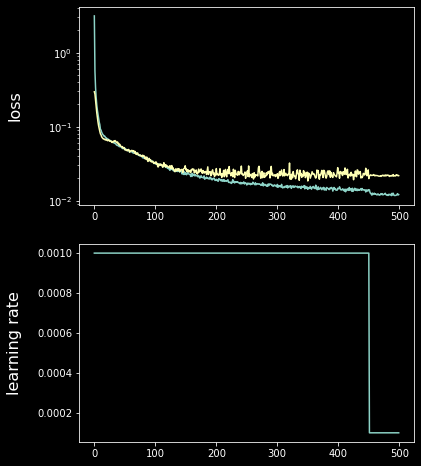

In [71]:
# Evaluating the model on the training and testing set
print("Final Training Loss: {0:.3}".format(history.history['val_loss'][-1]))
print("Final Testing Loss: {0:.3}".format(history.history['val_loss'][-1]))

import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
# source: https://stackoverflow.com/questions/31810461/python-matplotlib-vertically-aligned-plots-in-matplotlib

gs = gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(6,8))

#first plot
ax = fig.add_subplot(gs[0])
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_yscale('log')
ax.set_ylabel(r'loss', size=16)
ax.get_yaxis().set_label_coords(-0.17,0.5)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    labelbottom='off') # labels along the bottom edge are off

#second plot
ax = fig.add_subplot(gs[1], sharex=ax)
ax.plot(history.history['lr'])
ax.set_ylabel(r'learning rate', size =16)
ax.get_yaxis().set_label_coords(-0.17,0.5)

plt.show()